# Common link
* [Load Data](#load-data)
* [Split Data](#split-dataset)
* [Model](#model)
* [Evaluation](#evaluation)

In [1]:
feature = 29

# Model

In [2]:
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras.backend as K

In [3]:
encoder = None
ae = None
d = None
encoder_d = None
RAT = 115

In [4]:
def Encoder():
    input_layer = layers.Input(name='input', shape=(feature))
    #x = layers.Reshape((height, width, channels), name='ge_reshape')(input_layer)

    # Encoder
    x = layers.Dense(25, name='e_dense_1')(input_layer)
    x = layers.ReLU(name='e_relu_1')(x)

    x = layers.Dense(20, name='e_dense_2')(x)
    x = layers.ReLU(name='e_relu_2')(x)

    x = layers.Dense(15, name='e_dense_3')(x)
    x = layers.ReLU(name='e_relu_3')(x)

    x = layers.Dense(10, name='e_dense_4')(x)
    x = layers.ReLU(name='e_relu_4')(x)

    #x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

    encoder = keras.models.Model(inputs=input_layer, outputs=x)
    
    return encoder
    

In [5]:
def Decoder(encoder):
    input_layer = layers.Input(name='input', shape=(feature))

    x = encoder(input_layer)

    #decoder
    y = layers.Dense(15, name='dec_dense_1')(x)
    y = layers.ReLU(name='dec_relu_1')(y)

    y = layers.Dense(20, name='dec_dense_2')(y)
    y = layers.ReLU(name='dec_relu_2')(y)

    y = layers.Dense(25, name='dec_dense_3')(y)
    y = layers.ReLU(name='dec_relu_3')(y)

    y = layers.Dense(feature, name='dec_dense_4')(y)
    y = layers.ReLU(name='dec_relu_4')(y)

    ae = keras.models.Model(inputs=input_layer, outputs=y) #Autoencoder
    
    return ae

In [6]:
def Dis():
    input_layer = layers.Input(name='input', shape=(10))

    z = layers.Dense(10, name='dec_dense_1')(input_layer)
    z = layers.ReLU(name='dec_relu_1')(z)

    z = layers.Dense(10, name='dec_dense_2')(z)
    z = layers.ReLU(name='dec_relu_2')(z)

    z = layers.Dense(1, name='dec_dense_3')(z)
    z = layers.ReLU(name='dec_relu_3')(z)

    d = keras.models.Model(inputs=input_layer, outputs=z) #Discriminator
    
    return d

In [7]:
def Enoder_D(encoder, d):
    input_layer = layers.Input(name='input', shape=(feature))

    enc_latent = encoder(input_layer)
    valid = d(enc_latent)

    encoder_d = keras.models.Model(inputs=input_layer, outputs=valid)
    return encoder_d

In [8]:
def define_AAE():
    encoder = Encoder()
    ae = Decoder(encoder)
    ae.compile(optimizer = 'adam',
              loss = 'mse')
    d = Dis()
    d.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    encoder_d = Enoder_D(encoder, d)
    encoder_d.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    
    return encoder, ae, d, encoder_d

# Training

In [9]:
import numpy as np
niter = 1000
bz = 512

In [10]:
def train(x_train):
    half_bz = bz//2
    for i in range(niter):
        idx = np.random.randint(0, x_train.shape[0], half_bz)
        data = x_train[idx]
        
        # Generate a half batch of new images
        latent_fake = encoder.predict(data)
        latent_real = 5*np.random.normal(size=(half_bz, 10))
        valid = np.ones((half_bz, 1))
        fake = np.zeros((half_bz, 1))
        
        ### train disciminator ###
        d.trainable = True
        d_loss_real = d.train_on_batch(latent_real, valid)
        d_loss_fake = d.train_on_batch(latent_fake, fake)
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

        ### train autoencoder ###
        d.trainable = False 
        idx = np.random.randint(0, x_train.shape[0], bz)
        data = x_train[idx]
        valid_y = np.ones((bz, 1))
        g_loss = ae.train_on_batch(data, data)
        
        ### train generator ###
        g_logg_similarity = encoder_d.train_on_batch(data, valid_y)
        
        if i % 500 == 0:
            print ("%d [D loss: %f, acc: %.2f%%] [G acc: %f, mse: %f]" % (i, d_loss[0], 100*d_loss[1],
                    g_logg_similarity[1], g_loss))

# Evaluation

In [11]:
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

TPR_res, FPR_res, P_res, R_res = [], [], [], []
AUC_res, AUPRC_res = [], []
accuracies, fscore_res, recall_res, precision_res = [], [], [], []
reports = []
scores = []
THR_opt = []

def evaluation(x_test,y_test):
    recons_x = ae.predict(x_test)
    recons_loss = np.sum(np.square(recons_x - x_test), axis=-1)
    #print(recons_loss)
    print(recons_loss.shape)
    score = recons_loss
    score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
    #print(score)
    print(score.shape)
    score = score.reshape(len(score))

    nScore, abnScore = score[y_test==0], score[y_test==1]
    print('Scores of Normal and Abnormal:',nScore.shape,abnScore.shape)
    scores.append([nScore,abnScore])


    score = score.reshape(len(score))
    fpr, tpr, threshold_auc = roc_curve(y_score=score, y_true=y_test, pos_label=1)
    TPR_res.append(tpr)
    FPR_res.append(fpr)
    precision, recall, threshold_prc = precision_recall_curve(probas_pred=score, y_true=y_test, pos_label=1)
    P_res.append(precision)
    R_res.append(recall)
    
    auc_score = auc(fpr,tpr)
    auprc_score = auc(recall, precision)
    AUC_res.append(auc_score)
    AUPRC_res.append(auprc_score)


    # optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low.
    J = tpr - fpr
    ix1 = np.argmax(J)
    optimal_threshold = threshold_auc[ix1]
    #optimal_threshold = sorted(list(zip(np.sqrt(tpr-fpr), threshold_auc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUC:',optimal_threshold, 'TPR-FPR=',J[ix1])

    fscore = (2 * precision * recall) / (precision + recall)
    ix2 = np.nanargmax(fscore)
    optimal_prc_threshold = threshold_prc[ix2]
    #optimal_prc_threshold = sorted(list(zip(np.abs(precision - recall), threshold_prc)), key=lambda i: i[0], reverse=False)[0][1]
    print('Optimal threshold for best AUPRC:',optimal_prc_threshold,'f-score=', fscore[ix2])
    
    fscore_res.append(fscore[ix2])
    recall_res.append(recall[ix2])
    precision_res.append(precision[ix2])

    THR_opt.append({'AUC':optimal_threshold, 'PRC':optimal_prc_threshold})
    
    yTest_predict = [0 if s<=optimal_prc_threshold else 1 for s in score]
    class_report = classification_report(y_pred=yTest_predict, y_true=y_test, digits=4, output_dict=True)
    reports.append(class_report)
    accuracies.append(class_report['accuracy'])


# K-Fold Train

In [12]:
TOTAL_RUN = 10
run = 1

for run in range(1,TOTAL_RUN+1):
    encoder, ae, d, encoder_d = define_AAE()
    
    print('run: {!r}'.format(run))
    datasets = np.load('data/Runs/{!s}_{!s}_Runs/Run_{!s}.npz'.format(RAT,TOTAL_RUN, run))
    x_train, y_train = datasets['trainX'], datasets['trainY']
    x_test, y_test = datasets['testX'], datasets['testY']
    print('train:',x_train.shape,y_train.shape,'; ','test:',x_test.shape,y_test.shape)
    train(x_train=x_train)
    evaluation(x_test=x_test, y_test=y_test)
    run+=1

run: 1
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 7.246210, acc: 51.95%] [G acc: 0.000000, mse: 0.988937]
500 [D loss: 7.554427, acc: 40.04%] [G acc: 0.998047, mse: 0.749733]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.007632083361298215 TPR-FPR= 0.8093788465187116
Optimal threshold for best AUPRC: 0.028214019799948132 f-score= 0.4878457669740151
run: 2
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 4.165931, acc: 69.53%] [G acc: 0.000000, mse: 0.843198]
500 [D loss: 7.687061, acc: 49.61%] [G acc: 1.000000, mse: 0.673935]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.004926069217119679 TPR-FPR= 0.8214139775975605
Optimal threshold for best AUPRC: 0.032912485757003056 f-score= 0.4743589743589743
run: 3
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 7.507302, acc: 50.00%] [G acc: 0.000000, mse: 0.933680]
50

<ipython-input-11-616f16190d84>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 7.487329, acc: 50.78%] [G acc: 0.000000, mse: 1.314290]
500 [D loss: 7.592623, acc: 49.22%] [G acc: 1.000000, mse: 0.876067]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.005642988461935728 TPR-FPR= 0.8196676607833204
Optimal threshold for best AUPRC: 0.035357630763626226 f-score= 0.48762603116406966
run: 5
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 3.035046, acc: 76.37%] [G acc: 0.011719, mse: 1.046086]
500 [D loss: 7.583634, acc: 49.41%] [G acc: 1.000000, mse: 1.368045]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.006642511706227062 TPR-FPR= 0.8201169649088116
Optimal threshold for best AUPRC: 0.029619567084569722 f-score= 0.5035087719298246
run: 6
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 2.327673, acc: 81.64%] [G acc: 0.000000, mse: 0.980932]
500 [D l

<ipython-input-11-616f16190d84>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 0.113133, acc: 99.02%] [G acc: 0.005859, mse: 1.052044]
500 [D loss: 7.518276, acc: 50.20%] [G acc: 0.992188, mse: 0.694577]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.005416584657332166 TPR-FPR= 0.8256895871105977
Optimal threshold for best AUPRC: 0.025538160917766208 f-score= 0.5141342756183745
run: 9


<ipython-input-11-616f16190d84>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 4.115780, acc: 66.21%] [G acc: 0.000000, mse: 0.907356]
500 [D loss: 7.687094, acc: 48.24%] [G acc: 1.000000, mse: 0.916012]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.006497635689256347 TPR-FPR= 0.8198984608420553
Optimal threshold for best AUPRC: 0.02795835461822278 f-score= 0.47966804979253114
run: 10
train: (227452, 29) (227452,) ;  test: (57355, 29) (57355,)
0 [D loss: 4.901275, acc: 61.52%] [G acc: 0.000000, mse: 1.070366]
500 [D loss: 7.891999, acc: 46.09%] [G acc: 1.000000, mse: 0.637666]
(57355,)
(57355,)
Scores of Normal and Abnormal: (56863,) (492,)
Optimal threshold for best AUC: 0.005562903130664356 TPR-FPR= 0.8136773322958947
Optimal threshold for best AUPRC: 0.01790184979715085 f-score= 0.5209790209790209


<ipython-input-11-616f16190d84>:52: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


# Retrain
* [back to model](#model)

# AUC and PR curve

0.1


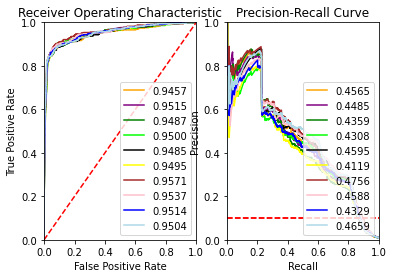

Average AUC score =  0.9506499504085486
Average AUPRC score =  0.44762029719970126
Average f1 score =  0.487178761955448
Average recall =  0.5699186991869919
Average precision =  0.42685548886701985
Average accuracy =  0.9896730886583558
[{'AUC': 0.007632083361298215, 'PRC': 0.028214019799948132}, {'AUC': 0.004926069217119679, 'PRC': 0.032912485757003056}, {'AUC': 0.00422702414370535, 'PRC': 0.03389874467169876}, {'AUC': 0.005642988461935728, 'PRC': 0.035357630763626226}, {'AUC': 0.006642511706227062, 'PRC': 0.029619567084569722}, {'AUC': 0.0068081905557794775, 'PRC': 0.02902091668153222}, {'AUC': 0.0011127835282529078, 'PRC': 0.006852760836308941}, {'AUC': 0.005416584657332166, 'PRC': 0.025538160917766208}, {'AUC': 0.006497635689256347, 'PRC': 0.02795835461822278}, {'AUC': 0.005562903130664356, 'PRC': 0.01790184979715085}]


In [13]:
rcParams['figure.figsize'] = 20, 5
#plot
fig, ax=plt.subplots(1,2)
proportion_of_abn = 152. / 1520.

colors = ['orange','purple','green','lime','black','yellow','brown','pink','blue','lightblue']
print(proportion_of_abn)


for i in range(len(TPR_res)):
    tpr, fpr = TPR_res[i], FPR_res[i]
    precision, recall = P_res[i], R_res[i]
    auc_score, auprc_score = AUC_res[i], AUPRC_res[i]
    indicator = colors[i]

    #ROC curve
    ax[0].plot(fpr, tpr, color = indicator, label = '%0.4f' % auc_score)
    ax[0].legend(loc = 'lower right')

    #PR curve
    ax[1].plot(recall, precision, color = indicator, label='%0.4f' % auprc_score)
    ax[1].legend(loc = 'lower right')
    


ax[0].set_title('Receiver Operating Characteristic')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].set_title('Precision-Recall Curve')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].plot([0, 1], [proportion_of_abn, proportion_of_abn],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
plt.show()

#calculate average AUC and AUPRC score
print('Average AUC score = ',sum(AUC_res) / TOTAL_RUN)
print('Average AUPRC score = ',sum(AUPRC_res) / TOTAL_RUN)
print('Average f1 score = ',sum(fscore_res) / TOTAL_RUN)
print('Average recall = ',sum(recall_res) / TOTAL_RUN)
print('Average precision = ',sum(precision_res) / TOTAL_RUN)
print('Average accuracy = ', sum(accuracies)/TOTAL_RUN)

print(THR_opt)

#print optnimal thresholds of 10 folds
#print(THR_opt)

In [14]:
TPR_maxlen = FPR_maxlen = P_maxlen = R_maxlen = 0

for i in range(len(TPR_res)):
    if TPR_maxlen < len(TPR_res[i]): TPR_maxlen = len(TPR_res[i])
    if FPR_maxlen < len(FPR_res[i]): FPR_maxlen = len(FPR_res[i])
    if P_maxlen < len(P_res[i]): P_maxlen = len(P_res[i])
    if R_maxlen < len(R_res[i]): R_maxlen = len(R_res[i])

def AddOn(addTo,data,row, dataLen):
    tmp = data[0]
    for i in range(dataLen):
        if i<len(data[row]) and data[row][i] is not np.nan: tmp = data[row][i]
        addTo[i]+=tmp

def AVG(data):
    return (data / TOTAL_RUN).tolist()
TPR_avg, FPR_avg, P_avg, R_avg = np.zeros((TPR_maxlen)), np.zeros((FPR_maxlen)), np.zeros((P_maxlen)), np.zeros((R_maxlen))

for i in range(len(TPR_res)):
    AddOn(TPR_avg, TPR_res, i, TPR_maxlen)
    AddOn(FPR_avg, FPR_res, i, FPR_maxlen)
    AddOn(P_avg, P_res, i, P_maxlen)
    AddOn(R_avg, R_res, i, R_maxlen)
    
TPR_avg, FPR_avg, P_avg, R_avg = AVG(TPR_avg), AVG(FPR_avg), AVG(P_avg), AVG(R_avg)

# Save Result to json

In [15]:
import json

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), "r", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)

with open('data/Runs/{!s}_{!s}_Runs/result.json'.format(RAT,TOTAL_RUN, run), 'w', encoding='utf-8') as jsonFile:
    data['AAE'] = {
            'AUC': AUC_res,
            'AUPRC': AUPRC_res,
            'Fscore': fscore_res,
            'Recall': recall_res,
            'Precision': precision_res,
            'Accuracy': accuracies,
            'THR_opt': THR_opt,
            'AVG': {
                'TPR': TPR_avg,
                'FPR': FPR_avg,
                'P': P_avg,
                'R': R_avg
            }
        }
    
    json.dump(data, jsonFile, ensure_ascii=False)

# End of Jupyter
* [To top](#common-link)